# Patsy
#### PyData Berlin
#### Canada Day, 2017
#### @maxhumber

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random

%matplotlib inline

In [2]:
def create_data():
    N = 1000
    beer = np.random.normal(loc=0, scale=1, size=N)
    warm = np.random.normal(loc=0, scale=1, size=N)
    family = np.random.randint(2, size=N)
    # linear combination
    z = 1 + 2*beer + -3*warm + 0.5*family
    # inv-logit function
    pr = [1 / (1 + np.exp(-i)) for i in z]
    canada = np.random.binomial(1, p=pr, size=N)
    # fake family into factor
    family = np.where(family == 0, 'No', 'Yes')
    return canada, beer, warm, family

In [3]:
np.random.seed(42)
canada, beer, warm, family = create_data()

df = pd.DataFrame({
    'canada':canada, 
    'beer':beer, 
    'warm':warm,
    'family':family})

In [4]:
df.head(10)

,beer,canada,family,warm
0,0.496714,0,Yes,1.399355
1,-0.138264,0,No,0.924634
2,0.647689,1,Yes,0.059630
3,1.523030,1,No,-0.646937
4,-0.234153,0,No,0.698223
5,-0.234137,0,Yes,0.393485
6,1.579213,1,No,0.895193
7,0.767435,0,Yes,0.635172
8,-0.469474,0,Yes,1.049553
9,0.542560,1,No,-0.535235


In [5]:
df.to_csv('canada.csv', index=False)

# Python Logistic Regression

In [6]:
# 0 - load modules

import pandas as pd
import statsmodels.api as sm

# 1 - load data 

df = pd.read_csv('canada.csv')

# X - dummy-fy 

df_dummy = pd.get_dummies(df, drop_first=True)

# X - create design matrix

X = df_dummy[['beer', 'warm', 'family_Yes']]
y = df_dummy['canada']

# X - add intercept

X['Intercept'] = 1

# 2 - test/train split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# 3 - model

mod = sm.Logit(y_train, X_train)

# X - fit model ??

result = mod.fit()

# 4 - peak 

result.summary()

/Users/personal/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.277336
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 canada   No. Observations:                  800
Model:                          Logit   Df Residuals:                      796
Method:                           MLE   Df Model:                            3
Date:                Sat, 01 Jul 2017   Pseudo R-squ.:                  0.5863
Time:                        09:17:31   Log-Likelihood:                -221.87
converged:                       True   LL-Null:                       -536.32
                                        LLR p-value:                5.483e-136
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
beer           2.2593      0.197     11.442      0.000       1.872       2.646
warm          -3.2297      0.253    -12.762      0.000      -3.726      -2.734
family_Yes     0.7244      0.244      2.967      0.003       0.246       1.203
Intercept      1.0736      0.183      5.862      0.000       0.715       1.433
==============================================================================
"""

# Patsy Logistic Regression

In [7]:
# 0 - load modules

from patsy import dmatrices, build_design_matrices
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import resample

# 1 - load data 

df = pd.read_csv('canada.csv')

# X - build design matrix with patsy 

y, X = dmatrices('canada ~ beer + warm + family', df, return_type='dataframe')
y = np.ravel(y)

# 2 - test/train split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# 3 - model

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=False)
model.fit(X_train, y_train)

# 4A - peak

from sklearn.metrics import accuracy_score, roc_auc_score

predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

print(accuracy_score(y_test, predicted))
print(roc_auc_score(y_test, probs[:, 1]))

# 4B - peak

from sklearn.model_selection import cross_val_score

scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

# 4C - peak

from sklearn.metrics import classification_report, confusion_matrix

expected = y_test
predicted = model.predict(X_test)

print(classification_report(expected, predicted))
print(confusion_matrix(expected, predicted))

0.84
0.925809163514
[ 0.88118812  0.93069307  0.86138614  0.89        0.86        0.86        0.87
  0.88888889  0.85858586  0.86868687]
0.876942894289
             precision    recall  f1-score   support

        0.0       0.82      0.76      0.79        78
        1.0       0.85      0.89      0.87       122

avg / total       0.84      0.84      0.84       200

[[ 59  19]
 [ 13 109]]


# Bonus

In [8]:
y_true = y_test
y_pred = model.predict_proba(X_test)[:, 1]

def separation_plot(y_true, y_pred):
    # prepare data
    sp = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    sp.sort_values('y_pred', inplace=True)
    sp['order'] = sp['y_pred'].rank(method='dense')
    sp['order'] = sp.order.astype(np.int64) 
    sp['height'] = 1
    sp['y_true'] = sp.y_true.astype(np.int64)   
    sp['color'] = ['b' if i == 0 else 'r' for i in sp['y_true']]
    sp = sp.reset_index(drop=True)
    # plot data
    plt.rcParams["figure.figsize"] = (12, 4)
    plt.bar(sp['order'], sp['height'], color=sp['color'], 
        alpha = 0.75, width = 1.01, antialiased=True)
    plt.plot(sp['order'], sp['y_pred'], c='black')
    plt.scatter(sp['y_pred'].sum(), 0.01, c='black', s=100, marker="^")
    plt.xticks([])
    plt.yticks([0, 0.5, 1])
    plt.ylabel('Predicted Value')
    plt.show()

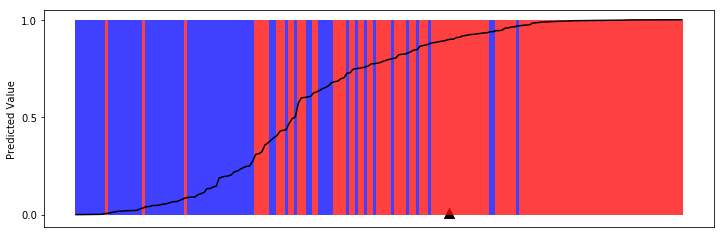

In [9]:
y_true = y_test
y_pred = model.predict_proba(X_test)[:, 1]

separation_plot(y_true, y_pred)

# Patsy Continued

In [10]:
design_info = X.design_info

def patsy_predict(design_info, model, new_data={}):
    new_data = pd.DataFrame(new_data, index=[0])
    print(new_data)
    (new_dmat, ) = build_design_matrices([design_info], new_data)
    return model.predict_proba(new_dmat)[:,1][0]

In [11]:
patsy_predict(design_info, model, {'beer': 1.5, 'warm': -0.5, 'family': 'Yes'})

   beer family  warm
0   1.5    Yes  -0.5


0.9981232609623909

In [12]:
patsy_predict(design_info, model, {'beer': -0.9, 'warm': 0.3, 'family': 'No'})

   beer family  warm
0  -0.9     No   0.3


0.1440113985711225

# Patsy Extended

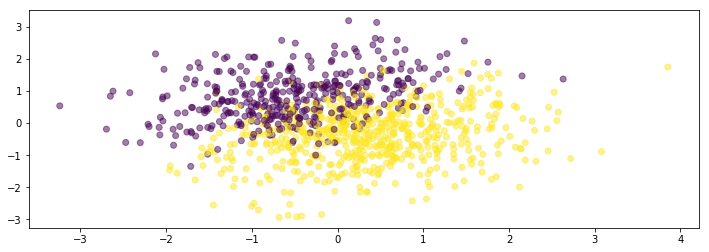

In [13]:
import patsy

def easy_scatter(formula, data={}):
    formula += ' - 1'
    y, X = patsy.dmatrices(formula, data, return_type='dataframe')
    y = np.ravel(y)
    return plt.scatter(X[X.columns[0]], X[X.columns[1]], c=y, alpha=0.5)
    
easy_scatter('canada ~ beer + warm', data = df)

# PyMC3

Optimization terminated successfully.
         Current function value: 313.527747
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22


100%|██████████| 2500/2500 [00:03<00:00, 677.06it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,0.924441,0.158042,0.004635,0.615665,1.230132
family[T.Yes],0.853001,0.212381,0.005096,0.424575,1.268325
beer,2.111556,0.168700,0.004887,1.796346,2.451385
warm,-3.068766,0.211180,0.006785,-3.487279,-2.659215


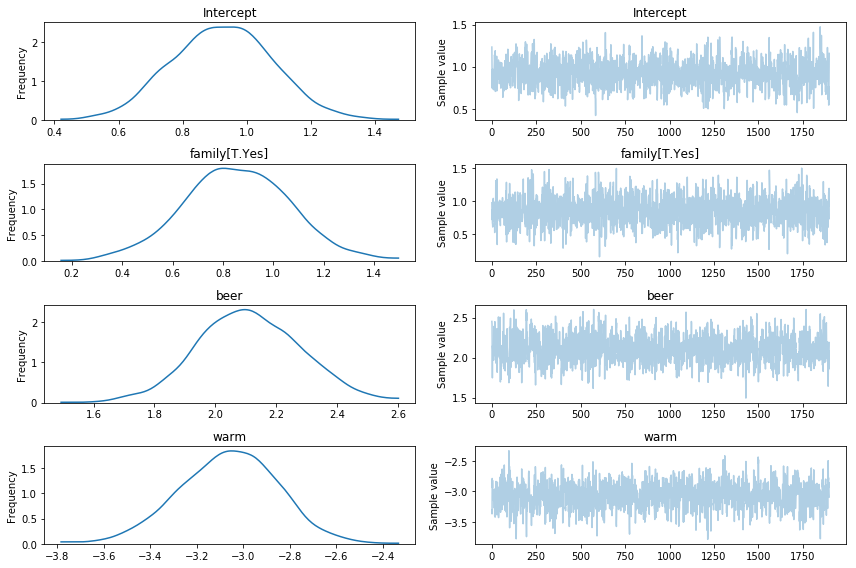

In [14]:
import pymc3 as pm

model = pm.Model()

with model:
    pm.glm.GLM.from_formula(
        'canada ~ beer + warm + family',
        data=df, family=pm.glm.families.Binomial())
    start = pm.find_MAP() # Use Maximum A Posteriori optimization as initial value for MCMC
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(2000, step, progressbar=True) # draw 2000 posterior samples using

plt.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
plt.tight_layout();

pm.df_summary(trace)